In [2]:
# Cell 1 – Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import os, numpy as np, cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

In [3]:
# Cell 2 – Environment variables + paths
# ⬇️ TODO: adjust for your machine / service‑account key
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token1.json'

DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'
TRAIN_FILES     = os.path.join(DATASET_FOLDER, '*.tfrecord-*')
print("🗂️  Dataset glob →", TRAIN_FILES)

🗂️  Dataset glob → gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/*.tfrecord-*


In [ ]:
# Cell 3 – Retrieve a single frame by context name
target_frame_name = 'ad58476e67ef355a35f3e5e3530587f2-077'
filenames = tf.io.matching_files(TRAIN_FILES)
dataset   = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()

data = None
for idx, bytes_example in enumerate(dataset_iter):
    frame_data = wod_e2ed_pb2.E2EDFrame()
    frame_data.ParseFromString(bytes_example)
    print(f'{idx:04d}:', frame_data.frame.context.name)
    if frame_data.frame.context.name == target_frame_name:
        data = frame_data
        print('Found frame!'); break
assert data is not None, 'Target frame not found'

2025-04-27 14:07:11.215916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 14:07:11.216292: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-27 14:07:12.538041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

0000: d6cdf6eb1b7d4a8be6dac71f34e6cdb7-164
0001: b197472f28df9f18c22654a5b514082a-072
0002: 2fc83038cb02199f1e530808f50e3862-070
0003: 57a6271444a065e7669292e6361fc2a1-136
0004: 670439f14c52d50310c70771896d002d-125
0005: ad58476e67ef355a35f3e5e3530587f2-077
🎯  Found frame!


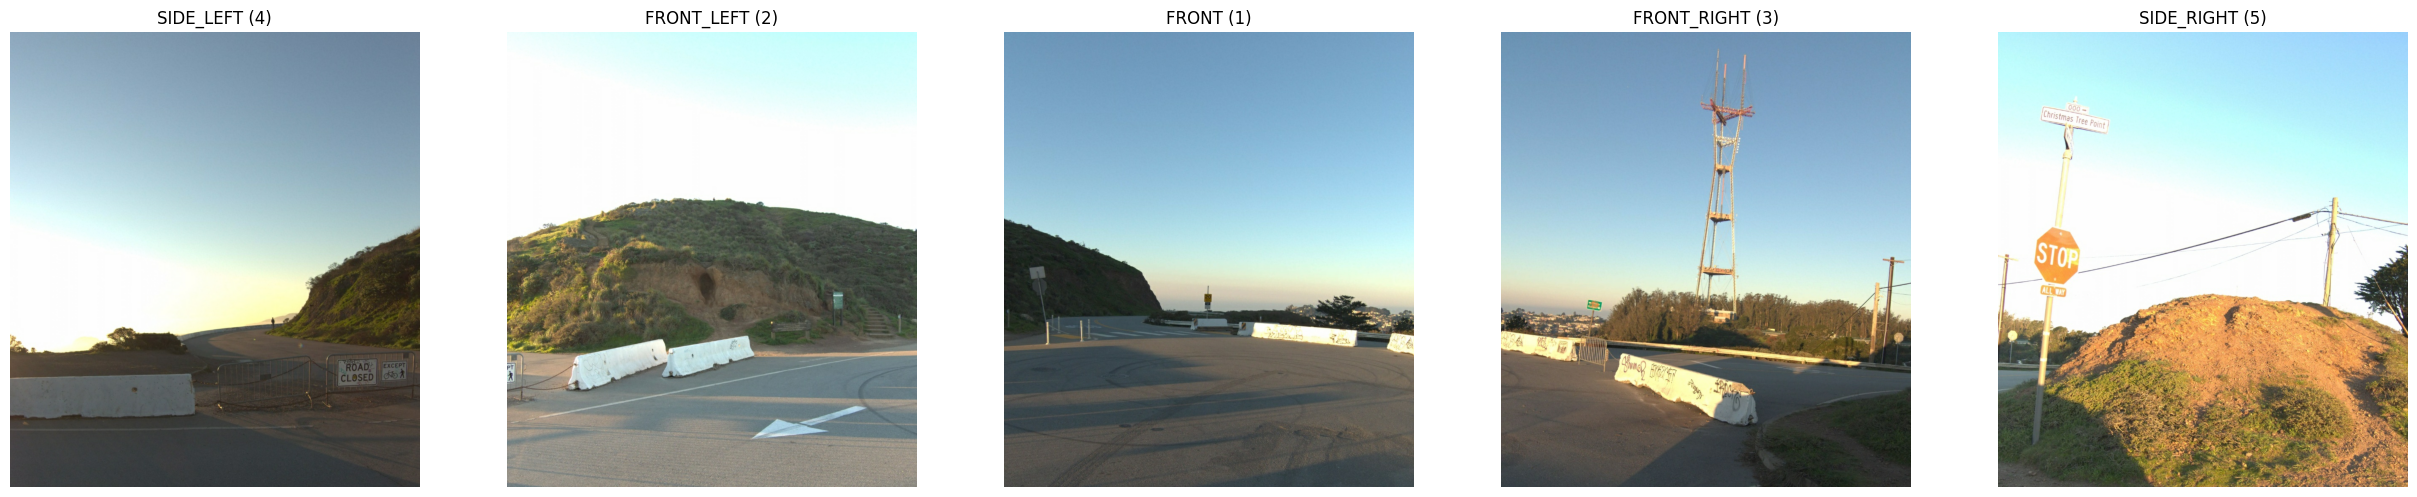

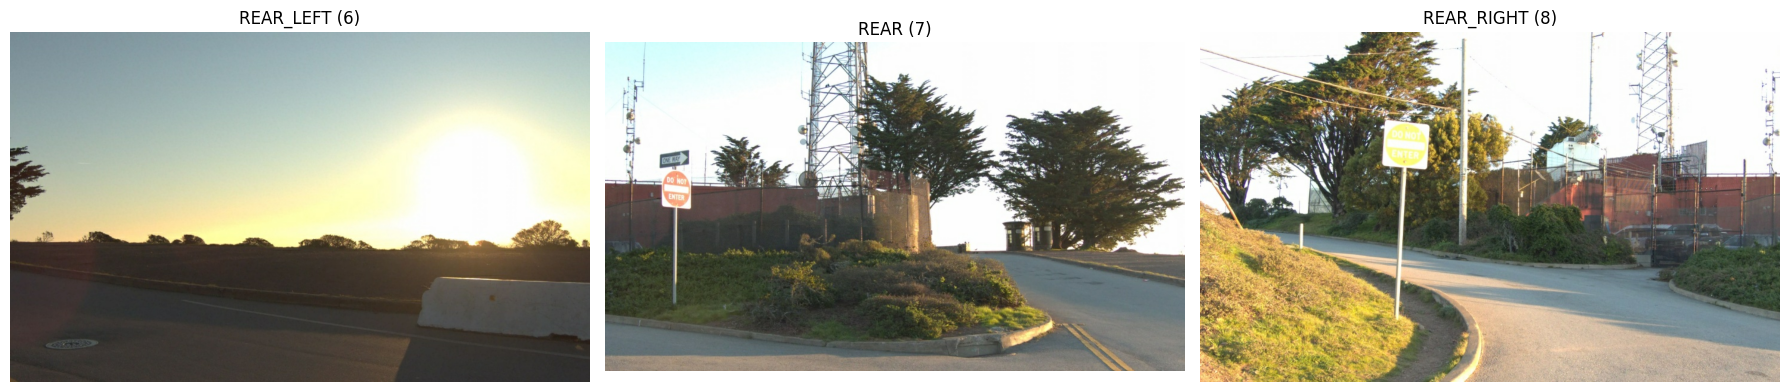

In [6]:
# Cell 4 – Visualise the 8 raw camera images
front_side_cameras = [
    open_dataset.CameraName.SIDE_LEFT,
    open_dataset.CameraName.FRONT_LEFT,
    open_dataset.CameraName.FRONT,
    open_dataset.CameraName.FRONT_RIGHT,
    open_dataset.CameraName.SIDE_RIGHT
]
back_cameras = [
    open_dataset.CameraName.REAR_LEFT,
    open_dataset.CameraName.REAR,
    open_dataset.CameraName.REAR_RIGHT
]

# Front + sides
fig1, axes1 = plt.subplots(1, 5, figsize=(25, 5))
for i, cam_id in enumerate(front_side_cameras):
    for image in data.frame.images:
        if image.name == cam_id:
            img_array = tf.io.decode_jpeg(image.image).numpy()
            cam_name  = open_dataset.CameraName.Name.Name(cam_id)
            axes1[i].imshow(img_array)
            axes1[i].set_title(f'{cam_name} ({cam_id})')
            axes1[i].axis('off')
            break
plt.tight_layout()
plt.show()

# Rear cameras
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
for i, cam_id in enumerate(back_cameras):
    for image in data.frame.images:
        if image.name == cam_id:
            img_array = tf.io.decode_jpeg(image.image).numpy()
            cam_name  = open_dataset.CameraName.Name.Name(cam_id)
            axes2[i].imshow(img_array)
            axes2[i].set_title(f'{cam_name} ({cam_id})')
            axes2[i].axis('off')
            break
plt.tight_layout()
plt.show()

In [7]:
# Cell 5 – Rectification helpers
def intrinsics_from_proto(intr):
    fu, fv, cu, cv = intr[:4]
    K = np.array([[fu, 0,  cu],
                  [0,  fv, cv],
                  [0,   0,  1]], np.float64)
    return K

def rectify_to_virtual(img, K_src, T_cam2veh, K_virtual,
                       T_virt2veh=np.eye(4), out_size=None):
    """Single‑plane homography (z=0 world plane)"""
    n = np.array([0., 0., 1.])                         # ground‑plane normal
    R_src, t_src = T_cam2veh[:3,:3], T_cam2veh[:3,3]
    R_dst, t_dst = T_virt2veh[:3,:3], T_virt2veh[:3,3]

    M_src = R_src - np.outer(t_src, n)
    M_dst = R_dst - np.outer(t_dst, n)

    H = K_virtual @ (M_dst @ np.linalg.inv(M_src)) @ np.linalg.inv(K_src)
    H /= H[2, 2]
    warped = cv2.warpPerspective(img, H,
                                 out_size or (int(K_virtual[0,2]*2), int(K_virtual[1,2]*2)),
                                 flags=cv2.INTER_LINEAR)
    return warped

✔︎ Rectified FRONT_LEFT to (1079, 972, 3)
✔︎ Rectified FRONT to (1079, 972, 3)
✔︎ Rectified FRONT_RIGHT to (1079, 972, 3)
✔︎ Rectified SIDE_LEFT to (1079, 972, 3)
✔︎ Rectified SIDE_RIGHT to (1079, 972, 3)
✔︎ Rectified REAR_RIGHT to (1079, 972, 3)
✔︎ Rectified REAR to (1079, 972, 3)
✔︎ Rectified REAR_LEFT to (1079, 972, 3)


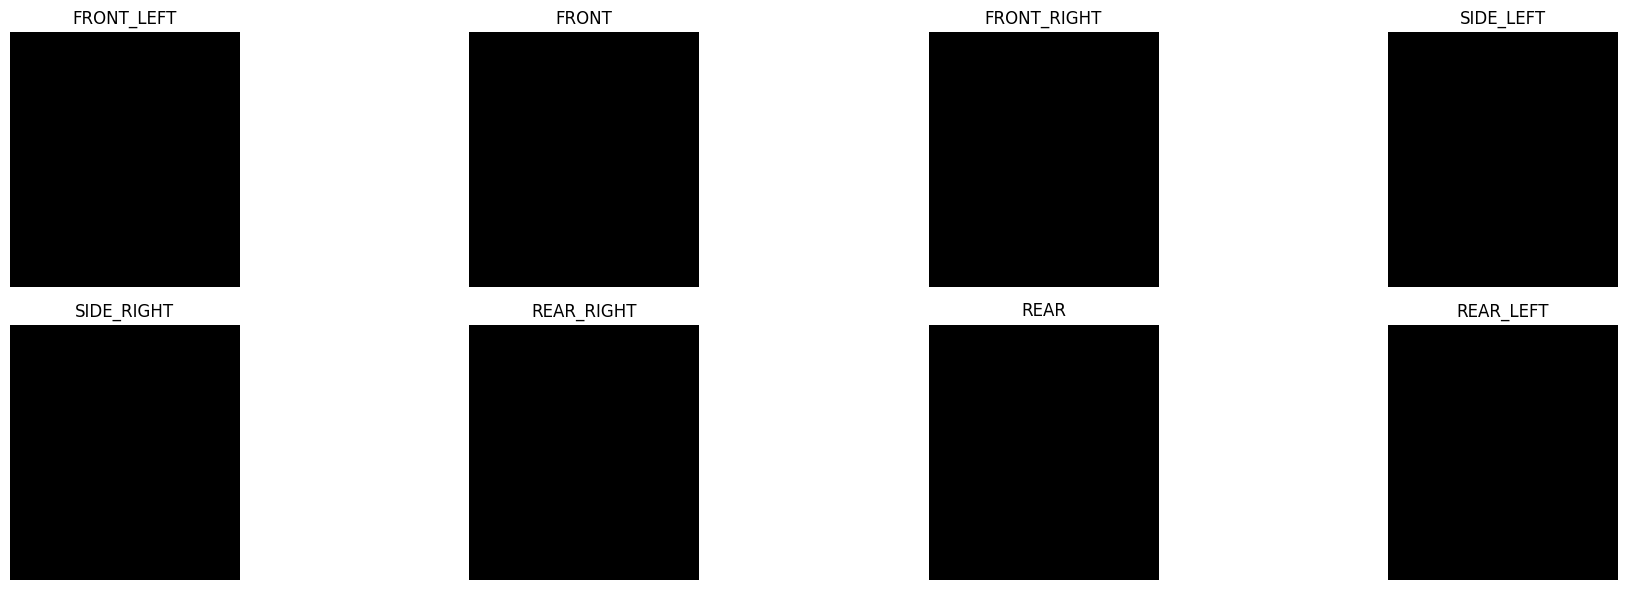

📐 Stacked tensor shape: (1079, 972, 24)


In [8]:
# Cell 6 – Rectify all 8 cameras into a common virtual pin‑hole view
virtual_size = (972, 1079)
K_virtual = np.array([[1112.48,    0.   , virtual_size[0]/2],
                      [   0.   , 1112.48, virtual_size[1]/2],
                      [   0.   ,    0.  ,               1. ]], np.float64)

rectified = {}
for image in data.frame.images:
    cam_id   = image.name
    cam_name = open_dataset.CameraName.Name.Name(cam_id)
    raw = tf.io.decode_jpeg(image.image).numpy()

    calib = None
    for c in data.frame.context.camera_calibrations:
        if c.name == cam_id:
            calib = c; break
    assert calib is not None, 'Calibration missing'
    K_src       = intrinsics_from_proto(calib.intrinsic)
    T_cam2veh   = np.array(calib.extrinsic.transform, np.float64).reshape(4,4)

    warped = rectify_to_virtual(raw, K_src, T_cam2veh, K_virtual,
                                out_size=virtual_size)
    rectified[cam_id] = warped
    print(f'✔︎ Rectified {cam_name} to {warped.shape}')

# Quick visual check
fig, axes = plt.subplots(2, 4, figsize=(20, 6))
for ax, (cam_id, img) in zip(axes.flat, rectified.items()):
    cam_name = open_dataset.CameraName.Name.Name(cam_id)
    ax.imshow(img)
    ax.set_title(cam_name)
    ax.axis('off')
plt.tight_layout(); plt.show()

# Stack to H×W×24 (ready for backbone)
stacked = np.concatenate([rectified[c] for c in sorted(rectified)], axis=2)
print('📐 Stacked tensor shape:', stacked.shape)